In [1]:
#Mouting drive for getting access to MyDrive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


##Importing required libraries

In [2]:
# Visualization Libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

# ML Libraries
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Evaluation Metrics
#from yellowbrick.classifier import ClassificationReport
from sklearn import metrics

##Loading preprocesses data for the classification purpose.

In [3]:
crime = pd.read_pickle("drive/My Drive/Colab Notebooks/CMPE_255_Project/Chicago_Crime_Processed_Data.pkl")

In [4]:
crime.head()

,IUCR,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Latitude,Longitude,Month,Day_num,Time,day_of_week,primary_type_grouped,zone,Count_CrimeType_Column
0,0486,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,924,9.0,12.0,61.0,08B,2015,41.815117,-87.670000,9,5,13,Saturday,NON-CRIMINAL_ASSAULT,South,1640154.0
1,0870,POCKET-PICKING,CTA BUS,False,False,1511,15.0,29.0,25.0,06,2015,41.895080,-87.765400,9,4,11,Friday,THEFT,North,2327482.0
3,2023,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,1412,14.0,35.0,21.0,18,2015,41.937406,-87.716650,9,5,12,Saturday,NARCOTIC_OFFENSE,West,661033.0
4,0560,SIMPLE,APARTMENT,False,True,1522,15.0,28.0,25.0,08A,2015,41.881903,-87.755121,9,5,13,Saturday,NON-CRIMINAL_ASSAULT,North,1640154.0
5,0610,FORCIBLE ENTRY,RESIDENCE,False,False,614,6.0,21.0,71.0,05,2015,41.744379,-87.658431,9,5,10,Saturday,THEFT,South,2327482.0


In [5]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6626783 entries, 0 to 7311029
Data columns (total 20 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   IUCR                    object 
 1   Description             object 
 2   Location Description    object 
 3   Arrest                  bool   
 4   Domestic                bool   
 5   Beat                    int64  
 6   District                float64
 7   Ward                    float64
 8   Community Area          float64
 9   FBI Code                object 
 10  Year                    int64  
 11  Latitude                float64
 12  Longitude               float64
 13  Month                   int64  
 14  Day_num                 int64  
 15  Time                    int64  
 16  day_of_week             object 
 17  primary_type_grouped    object 
 18  zone                    object 
 19  Count_CrimeType_Column  float64
dtypes: bool(2), float64(6), int64(5), object(7)
memory usage: 973.2+ MB


In [6]:
crime.isnull().sum().sum()

5348

In [7]:
crime.apply(lambda x: sum(x.isnull()),axis=0)

IUCR                         0
Description                  0
Location Description         0
Arrest                       0
Domestic                     0
Beat                         0
District                     0
Ward                         0
Community Area               0
FBI Code                     0
Year                         0
Latitude                     0
Longitude                    0
Month                        0
Day_num                      0
Time                         0
day_of_week                  0
primary_type_grouped      2674
zone                         0
Count_CrimeType_Column    2674
dtype: int64

In [8]:
crime['primary_type_grouped'].unique()

array(['NON-CRIMINAL_ASSAULT', 'THEFT', 'NARCOTIC_OFFENSE',
       'OTHER_OFFENSE', 'CRIMINAL_OFFENSE', 'WEAPONS_OFFENSE',
       'SEXUAL_OFFENSE', 'HUMAN_TRAFFICKING_OFFENSE', nan], dtype=object)

In [9]:
cime= crime.dropna(inplace=True)
crime = crime.reset_index(drop=True)

In [10]:
crime['primary_type_grouped'].unique()

array(['NON-CRIMINAL_ASSAULT', 'THEFT', 'NARCOTIC_OFFENSE',
       'OTHER_OFFENSE', 'CRIMINAL_OFFENSE', 'WEAPONS_OFFENSE',
       'SEXUAL_OFFENSE', 'HUMAN_TRAFFICKING_OFFENSE'], dtype=object)

In [11]:
crime.shape

(6624109, 20)

##Data processing further for applying random forest model.

In [12]:
# Convert Categorical Attributes to Numerical
for col_name in crime.columns:
    if(crime[col_name].dtype == 'object'):
        crime[col_name]= crime[col_name].astype('category')
        crime[col_name] = crime[col_name].cat.codes

In [13]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6624109 entries, 0 to 6624108
Data columns (total 20 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   IUCR                    int16  
 1   Description             int16  
 2   Location Description    int16  
 3   Arrest                  bool   
 4   Domestic                bool   
 5   Beat                    int64  
 6   District                float64
 7   Ward                    float64
 8   Community Area          float64
 9   FBI Code                int8   
 10  Year                    int64  
 11  Latitude                float64
 12  Longitude               float64
 13  Month                   int64  
 14  Day_num                 int64  
 15  Time                    int64  
 16  day_of_week             int8   
 17  primary_type_grouped    int8   
 18  zone                    int8   
 19  Count_CrimeType_Column  float64
dtypes: bool(2), float64(6), int16(3), int64(5), int8(4)
memory usage: 63

##To check correlation between different variables.

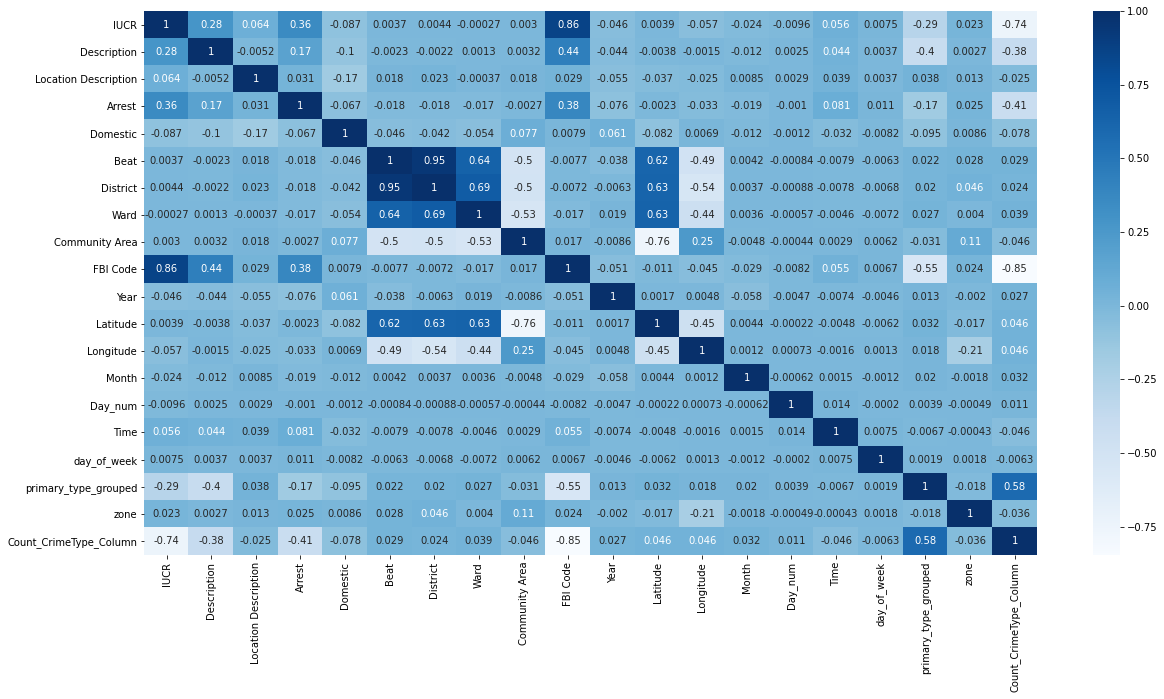

In [14]:
# Feature Selection using Filter Method 
# Split Dataframe to target class and features
X_fs = crime.drop(['primary_type_grouped'], axis=1)
Y_fs = crime['primary_type_grouped']

#Using Pearson Correlation
plt.figure(figsize=(20,10))
cor = crime.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

In [22]:
#Correlation with output variable
cor_target = abs(cor['primary_type_grouped'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.01]
relevant_features

IUCR                      0.292668
Description               0.398370
Location Description      0.038127
Arrest                    0.166601
Domestic                  0.095439
Beat                      0.022295
District                  0.019958
Ward                      0.027361
Community Area            0.031119
FBI Code                  0.548101
Year                      0.012579
Latitude                  0.031977
Longitude                 0.017794
Month                     0.019630
primary_type_grouped      1.000000
zone                      0.017890
Count_CrimeType_Column    0.582641
Name: primary_type_grouped, dtype: float64

##We can see that the three features are highly related with target crime type "primary_type_grouped" which is obvious as these are the attribuets which are updated after crime happened .Attributes like "FBI Code", "ICUR" and "Description". So for this classification we will be usig attributes which are constant and before crime to predict a crime type to take needed precautions like increasing pnumber of police and so forth. 

In [24]:
# At Current Point, the attributes is select manually based on Feature Selection Part. 
#Features = ["IUCR", "Location Description", "FBI Code"]
Features = ["District","Ward","Community Area","Latitude","Longitude","Month","Year","Time","zone","Location Description","Beat"]
print('Full Features: ', Features)

Full Features:  ['District', 'Ward', 'Community Area', 'Latitude', 'Longitude', 'Month', 'Year', 'Time', 'zone', 'Location Description', 'Beat']


In [18]:
target ='primary_type_grouped'

##Splitting data in training and testing.

In [25]:
#Split dataset to Training Set & Test Set
x, y = train_test_split(crime, 
                        test_size = 0.2, 
                        train_size = 0.8, 
                        random_state= 3)

x1 = x[Features]    #Features to train
x2 = x[target]      #Target Class to train
y1 = y[Features]    #Features to test
y2 = y[target]      #Target Class to test

print('Feature Set Used    : ', Features)
print('Target Class        : ', target)
print('Training Set Size   : ', x.shape)
print('Test Set Size       : ', y.shape)

Feature Set Used    :  ['District', 'Ward', 'Community Area', 'Latitude', 'Longitude', 'Month', 'Year', 'Time', 'zone', 'Location Description', 'Beat']
Target Class        :  primary_type_grouped
Training Set Size   :  (5299287, 20)
Test Set Size       :  (1324822, 20)


##Creating Random forest model.

In [27]:
# Random Forest
# Create Model with configuration
#rf_model = RandomForestClassifier()--------crashes the system

#rf_model = RandomForestClassifier(n_estimators=200, # Number of trees
#                                  min_samples_split = 30,
#                                  bootstrap = True, 
#                                  max_depth = 100, 
#                                  min_samples_leaf = 25)

rf_model = RandomForestClassifier(n_estimators=100, # Number of trees    -----------48 %
                                  min_samples_split = 30,
                                  bootstrap = True, 
                                  max_depth = 50, 
                                  min_samples_leaf = 25)

# Model Training
rf_model.fit(X=x1,y=x2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=25, min_samples_split=30,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [28]:
y_pred_train = rf_model.predict(x1)

##Applying trained model to test data and getting predicted crime types.

In [29]:
#Feed the features of the test images to Random Forest Classifier to predict its class
y_pred_test= rf_model.predict(y1)

##Testing Accuracy for RF2 model.

In [30]:
#Testing accuracy
accuracy=accuracy_score(y_pred_test, y2)
print('Accuracy for testing data for RF model:', accuracy*100, '%.')

Accuracy for testing data for RF model: 48.12850330082079 %.


##Testing Accuracy is very less of 48.12 %.

In [31]:
#target_names = Classes
target_names = ['CRIMINAL_OFFENSE','HUMAN_TRAFFICKING_OFFENSE','NARCOTIC_OFFENSE','NON_CRIMINAL_ASSAULT','OTHER_OFFENSE','SEXUAL_OFFENSE','THEFT','WEAPONS_OFFENSE']   

##Classification reports for Training and Testing.

In [32]:
# testing metrics
print("Testing metrics:")
print(classification_report(y_true= y2, y_pred= y_pred_test, target_names=target_names))

Testing metrics:
                           precision    recall  f1-score   support

         CRIMINAL_OFFENSE       0.48      0.14      0.21    245749
HUMAN_TRAFFICKING_OFFENSE       0.59      0.01      0.01     10293
         NARCOTIC_OFFENSE       0.53      0.47      0.50    132168
     NON_CRIMINAL_ASSAULT       0.44      0.53      0.48    328591
            OTHER_OFFENSE       0.42      0.03      0.06    102717
           SEXUAL_OFFENSE       0.70      0.29      0.41     22405
                    THEFT       0.49      0.76      0.60    466304
          WEAPONS_OFFENSE       0.39      0.01      0.02     16595

                 accuracy                           0.48   1324822
                macro avg       0.51      0.28      0.29   1324822
             weighted avg       0.48      0.48      0.43   1324822



In [33]:
# training metrics
print("Training metrics:")
print(classification_report(y_true=x2 , y_pred= y_pred_train, target_names=target_names))


Training metrics:
                           precision    recall  f1-score   support

         CRIMINAL_OFFENSE       0.59      0.18      0.27    985012
HUMAN_TRAFFICKING_OFFENSE       0.70      0.01      0.02     41153
         NARCOTIC_OFFENSE       0.57      0.51      0.54    528865
     NON_CRIMINAL_ASSAULT       0.49      0.59      0.53   1311563
            OTHER_OFFENSE       0.59      0.05      0.09    414371
           SEXUAL_OFFENSE       0.73      0.30      0.43     90490
                    THEFT       0.52      0.80      0.63   1861178
          WEAPONS_OFFENSE       0.49      0.02      0.03     66655

                 accuracy                           0.52   5299287
                macro avg       0.59      0.31      0.32   5299287
             weighted avg       0.54      0.52      0.47   5299287



##Confusion matrix for testing data.

In [34]:
# Visualise classical Confusion M0atrix
CM = confusion_matrix(y2, y_pred_test)
print(CM)

[[ 33296     11   7467  58363   1116    321 145132     43]
 [   968     54    197   5527    123      6   3416      2]
 [  3606      5  62418  26950    283    664  38202     40]
 [ 10609      5  21810 175652   1257    571 118604     83]
 [  6099      5   6454  38668   3139    220  48094     38]
 [   618      9   1602   5498     72   6445   8155      6]
 [ 13272      3  15657  78557   1412    894 356417     92]
 [   393      0   2141   6598    102     40   7125    196]]


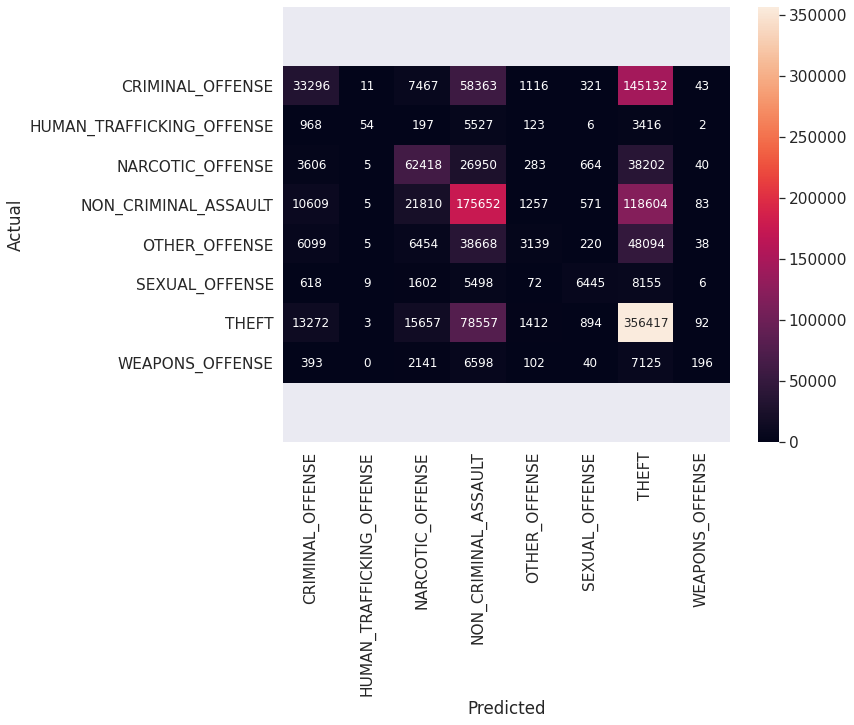

In [35]:
# Visualize it as a heatmap
#cmap="YlGnBu"
sns.set(font_scale=1.4) # for label size
ax = plt.subplots(figsize=(10, 8))
ax=sns.heatmap(CM,annot=True,annot_kws={"size": 12},fmt='d',xticklabels=target_names, yticklabels=target_names,cmap="rocket")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 1.5, top - 1.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##Saving this RF2 model for using with sample data directly.

In [37]:
import os
print(os.listdir(r"drive/My Drive/Colab Notebooks/CMPE_255_Project"))

['Chicago_Crime', 'Chicago_Crime_Processed_Data.pkl', 'Sample_Data.pkl', 'RF1.joblib', 'Sample_Data_Proj.pkl']


In [36]:
import joblib

In [38]:
# save
joblib.dump(rf_model, "drive/My Drive/Colab Notebooks/CMPE_255_Project/RF2.joblib")

['drive/My Drive/Colab Notebooks/CMPE_255_Project/RF2.joblib']